In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Set working directory to '/n/groups/patel/shakson/aiready/'
import os
os.chdir("/home/shaksonisaac/CGM/mambatf/")

In [16]:
#LOAD Datasets
import pandas as pd
import io
from google.cloud import storage

_BUCKET_NAME = "cgmproject2025"

# Download dataset from GCS
client = storage.Client()
bucket = client.bucket(_BUCKET_NAME)
blob = bucket.blob('ai-ready/data/train_timeseries_meal.feather')
data_bytes = blob.download_as_bytes()
train = pd.read_feather(io.BytesIO(data_bytes))


# Download test set:
client = storage.Client()
bucket = client.bucket(_BUCKET_NAME)
blob = bucket.blob('ai-ready/data/test_timeseries_meal.feather')
data_bytes = blob.download_as_bytes()
test = pd.read_feather(io.BytesIO(data_bytes))



In [6]:
# Load Data
import os
import sys

#from TFT_pytorch import log_memory, create_tft_dataloaders, TFT_train
from scripts.mamba288 import create_tft_dataloaders, TFT_train, save_tft_to_gcs, load_tft_from_gcs

In [7]:
# Rebuild the training dataset (same context_length, horizon, etc.)
training, val_dataloader, train_dataloader, validation = create_tft_dataloaders(train, horizon=12, context_length=288, batchsize=32)

[2025-08-04 16:28:00.658708] Start of Dataloader Creation
GPU Mem allocated: 0.00 GB | reserved: 0.00 GB


In [9]:
tft = load_tft_from_gcs(model_name="MambaTFT_12horizon_288context_meal", training_dataset=training)
tft.eval()  # Put model in evaluation mode

/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Loaded TFT from gs://cgmproject2025/models/predictions/MambaTFT_12horizon_288context_meal/


MambaTFT(
  	"attention_head_size":               2
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'ds', 'target': 'cgm_glucose', 'group_ids': ['participant_id'], 'weight': None, 'max_encoder_length': 288, 'min_encoder_length': 288, 'min_prediction_idx': np.int64(11), 'min_prediction_length': 12, 'max_prediction_length': 12, 'static_categoricals': ['participant_id', 'clinical_site', 'study_group'], 'static_reals': ['age'], 'time_varying_known_categoricals': ['sleep_stage'], 'time_varying_known_reals': ['ds', 'minute_of_day', 'tod_sin', 'tod_cos', 'activity_steps', 'calories_value', 'heartrate', 'oxygen_saturation', 'respiration_rate', 'stress_level', 'predmeal_flag'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['cgm_glucose', 'cgm_lag_1', 'cgm_lag_3', 'cgm_lag_6', 'cgm_diff_lag_1', 'cgm_diff_lag_3', 'cgm_diff_lag_6', 'cgm_lagdiff_1_3', 'cgm_lagdiff_3_6', 'cgm_roll

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/lightning

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x375 with 1 Axes>,
 'encoder_variables': <Figure size 700x800 with 1 Axes>,
 'decoder_variables': <Figure size 700x525 with 1 Axes>}

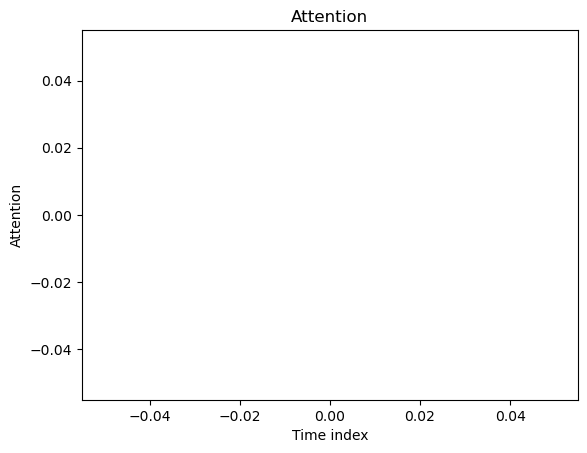

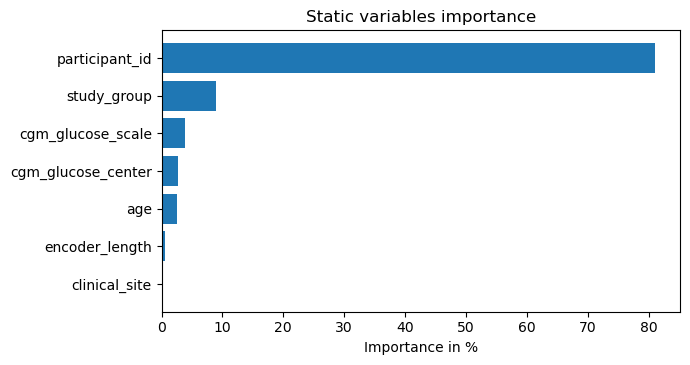

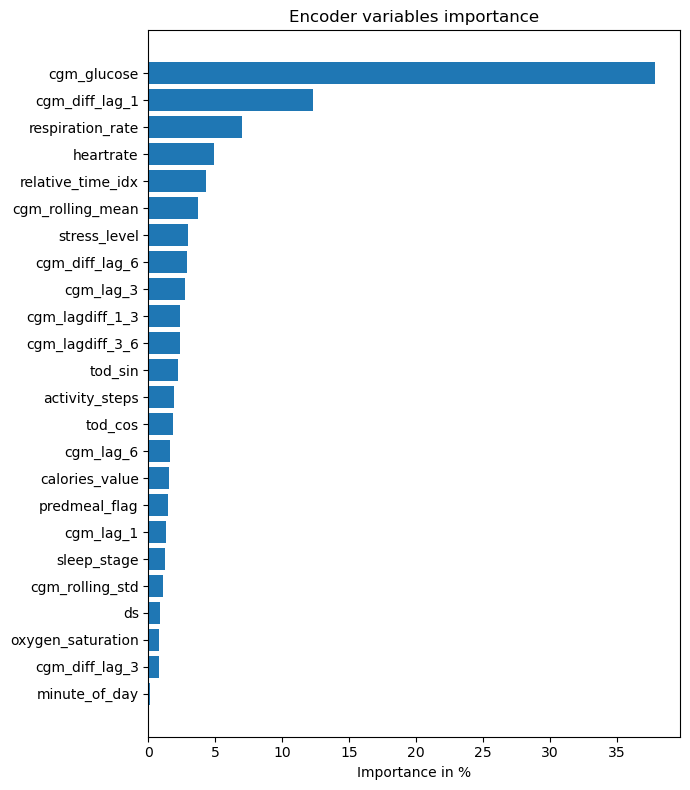

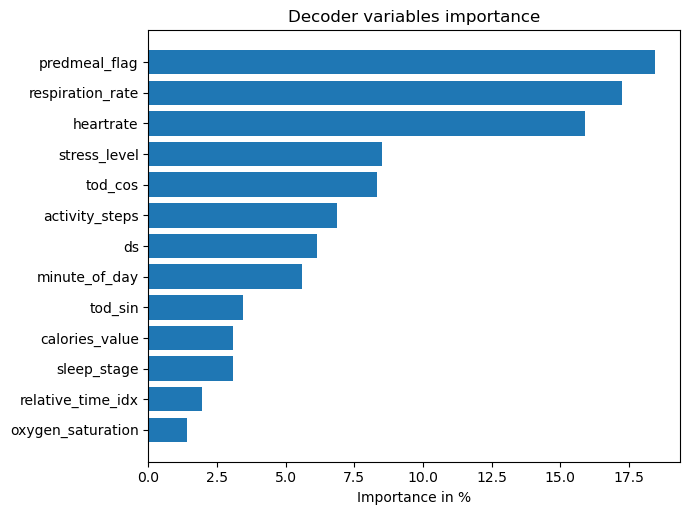

In [10]:
# --- Prédiction ---
# Assure-toi que val_dataloader est bien structuré
y_hat_raw = tft.predict(val_dataloader, mode="raw")
# --- Visualisation des interprétations ---
interpretation = tft.interpret_output(y_hat_raw, reduction="sum")
tft.plot_interpretation(interpretation)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Shape of y_pred: torch.Size([741, 12, 3])


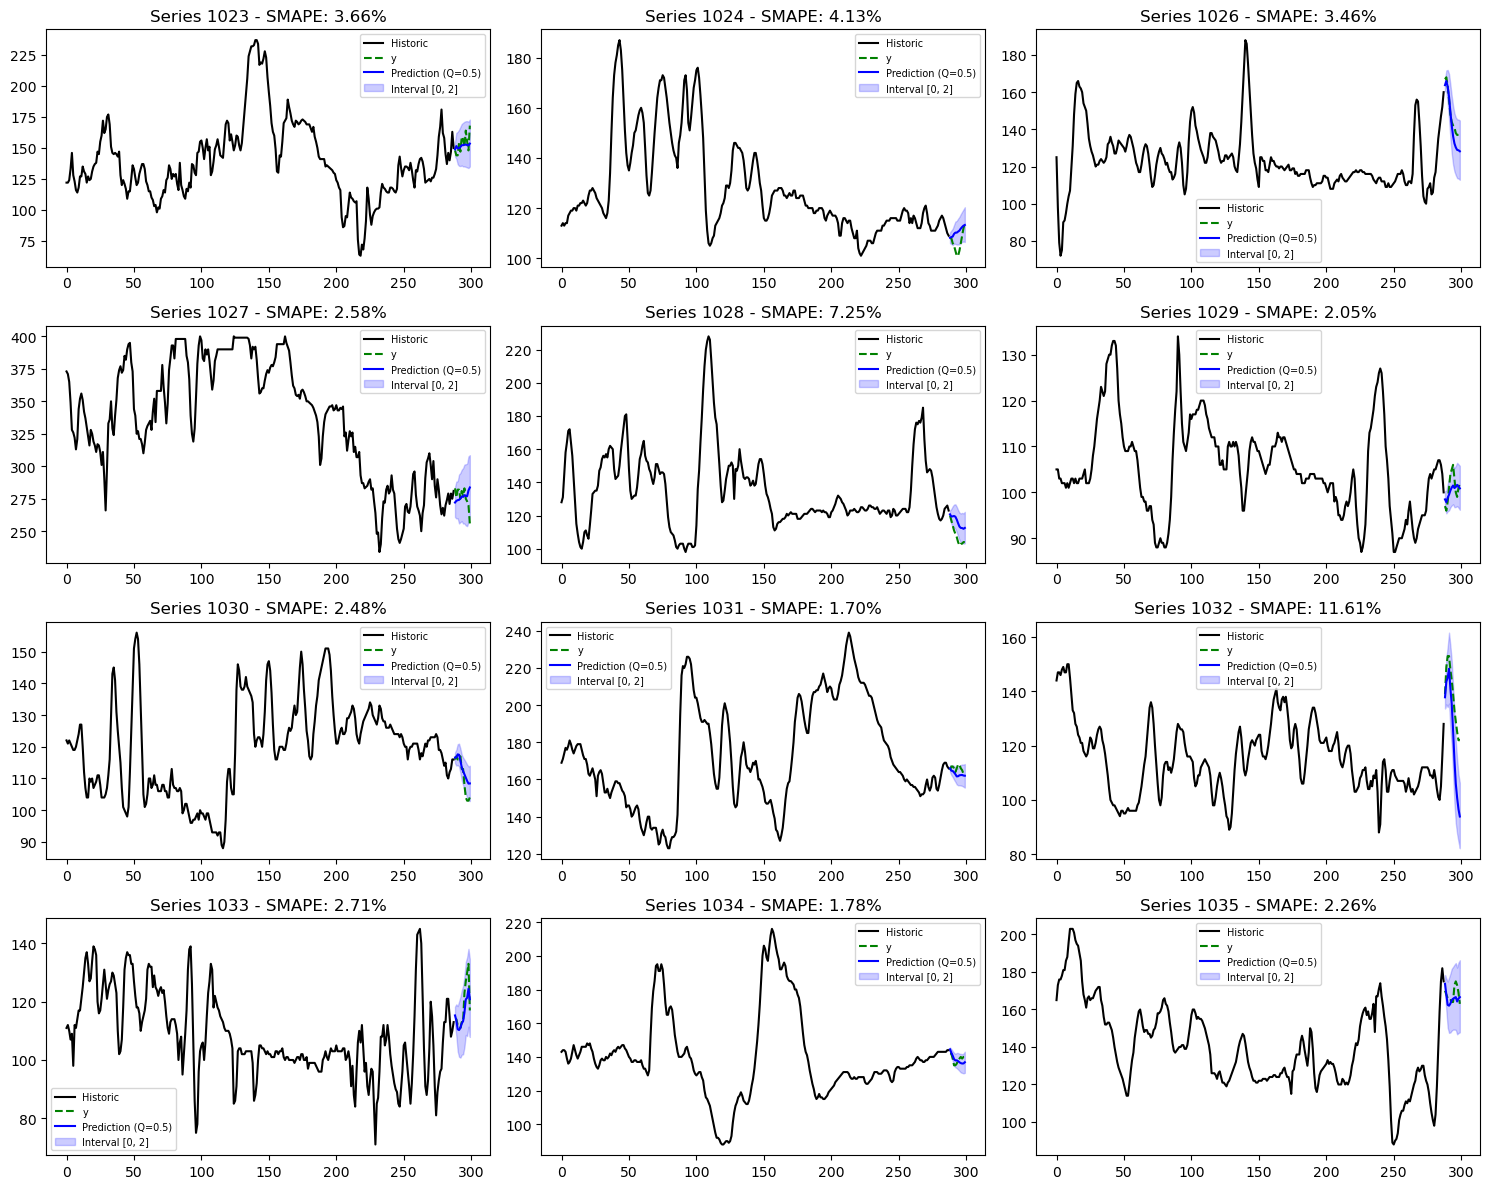

In [11]:
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    )
def quantile_loss(y_true, y_pred, q):
    error = y_true - y_pred
    return np.mean(np.maximum(q * error, (q - 1) * error))
# Récupération des prédictions brutes
raw_preds = tft.predict(val_dataloader, mode="raw", return_x=True, return_index=True)
# Forme : [batch, decoder_len, num_quantiles]
y_pred = raw_preds.output["prediction"]
print("Shape of y_pred:", y_pred.shape)
y_true = raw_preds.x["decoder_target"]
x = raw_preds.x
index_df = raw_preds.index
# Supposons : quantiles = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
# Et la médiane (0.5) est à l’index 3 (c’est le cas ici d’après toi)
median_idx = 1
q_low = 0  # index du quantile bas (ex: 0.1)
q_high = 2  # index du quantile haut (ex: 0.9)

# Parameters for the grid
n_rows, n_cols = 4, 3
n_plots = n_rows * n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3), squeeze=False)

for i in range(min(n_plots, len(index_df))):
    uid = index_df.iloc[i]["participant_id"]
    time_start = index_df.iloc[i]["ds"]
    encoder_len = x["encoder_lengths"][i].item()
    decoder_len = y_pred.shape[1]
    encoder_target = x["encoder_target"][i, :encoder_len].detach().cpu().numpy()
    target = y_true[i].detach().cpu().numpy()
    pred_all = y_pred[i].detach().cpu().numpy()
    pred_median = pred_all[:, median_idx]
    pred_q_low = pred_all[:, q_low]
    pred_q_high = pred_all[:, q_high]
    
    # SMAPE
    loss = smape(target, pred_median)
    
    # Get subplot axis
    row, col = divmod(i, n_cols)
    ax = axs[row][col]

    # Plot encoder/historical
    ax.plot(range(encoder_len), encoder_target, label="Historic", color="black")
    # Plot actual target
    ax.plot(
        range(encoder_len, encoder_len + decoder_len),
        target,
        label="y",
        color="green",
        linestyle="--",
    )
    # Plot prediction (median)
    ax.plot(
        range(encoder_len, encoder_len + decoder_len),
        pred_median,
        label="Prediction (Q=0.5)",
        color="blue",
    )
    # Plot prediction interval
    ax.fill_between(
        range(encoder_len, encoder_len + decoder_len),
        pred_q_low,
        pred_q_high,
        color="blue",
        alpha=0.2,
        label=f"Interval [{q_low}, {q_high}]",
    )

    ax.set_title(f"Series {uid} - SMAPE: {loss:.2f}%")
    ax.legend(fontsize=7)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [12]:
# Get global metrics:
raw_preds = tft.predict(val_dataloader, mode="raw", return_x=True, return_index=True)
print("Shape of raw_preds:", raw_preds.output["prediction"].shape)
y_pred = raw_preds.output["prediction"][:, :, 1] #To get median quantile.
y_true = raw_preds.x["decoder_target"]
index_df = raw_preds.index
records = []
for i in range(len(index_df)):
    uid = index_df.iloc[i]["participant_id"]
    time_start = index_df.iloc[i]["ds"]
    for t in range(y_pred.shape[1]):
        records.append({
            "participant_id": uid,
            "ds": int(time_start + t),
            "target": float(y_true[i, t]),
            "prediction": float(y_pred[i, t]),
        })
records = pd.DataFrame(records)
print(records.head())

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Shape of raw_preds: torch.Size([741, 12, 3])
  participant_id    ds  target  prediction
0           1023  2832   148.0  148.815460
1           1023  2833   144.0  151.497452
2           1023  2834   144.0  149.669907
3           1023  2835   154.0  149.739441
4           1023  2836   147.0  150.785309


In [13]:
import numpy as np
import pandas as pd
def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8)
    )
def quantile_loss(y_true, y_pred, q=0.5):
    return np.mean(np.maximum(q * (y_true - y_pred), (q - 1) * (y_true - y_pred)))
def calculate_metrics(t_grouped, train_df):
    static_vars = train_df[
        [
            "participant_id",
        ]
    ].drop_duplicates()
    t_grouped = t_grouped.merge(static_vars, on="participant_id", how="left")
    metrics_df = (
        t_grouped.groupby("participant_id")
        .apply(
            lambda df: pd.Series(
                {
                    "SMAPE": smape(df["target"], df["prediction"]),
                    "Quantile_Loss": quantile_loss(df["target"], df["prediction"]),
                    "MAE": np.mean(np.abs(df["prediction"] - df["target"])),
                    "RMSE": np.sqrt(np.mean(np.square(df["prediction"] - df["target"]))),
                }
            )
        )
        .reset_index()
    )
    return metrics_df

/tmp/ipykernel_67537/3904849015.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/tmp/ipykernel_67537/4266719315.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=metrics)


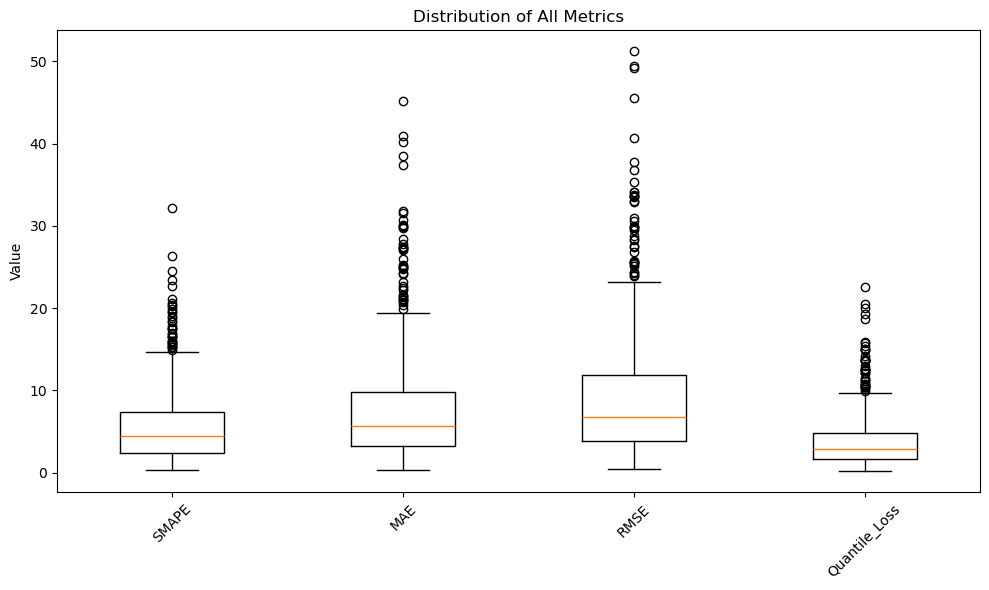

In [14]:
import pandas as pd
import matplotlib.pyplot as plt


metrics_df = calculate_metrics(records, train)

# 1. Melt your wide metrics_df into long form
long_df = metrics_df.melt(
    value_vars=["SMAPE", "MAE", "RMSE", "Quantile_Loss"],
    var_name="metric",
    value_name="value"
)

# 2. Prepare data arrays for each metric
metrics = ["SMAPE", "MAE", "RMSE", "Quantile_Loss"]
data = [long_df.loc[long_df["metric"] == m, "value"] for m in metrics]

# 3. Plot side-by-side boxplots
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=metrics)
plt.xticks(rotation=45)
plt.title("Distribution of All Metrics")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

In [15]:
average_metrics = metrics_df[["SMAPE", "MAE", "RMSE", "Quantile_Loss"]].mean().to_frame(name="Average").reset_index()
average_metrics.columns = ["Metric", "Average"]
print(average_metrics)

          Metric   Average
0          SMAPE  5.631655
1            MAE  7.559374
2           RMSE  8.912611
3  Quantile_Loss  3.779687


In [19]:
context_length = 288  # Length of the context window

# --- Rebuild the test dataset with context ---
# This assumes you have a context length of 72 and a horizon of 12
# You can adjust these parameters as needed.
# Suppose you still have access to the full `train` dataframe
combined_test = []

for pid in test["participant_id"].unique():
    test_part = test[test["participant_id"] == pid]
    train_part = train[train["participant_id"] == pid].sort_values("ds")

    # Get last 72 from train and concat with 12 test rows
    encoder_part = train_part.iloc[-context_length:]
    combined = pd.concat([encoder_part, test_part], axis=0)
    combined_test.append(combined)

test_full = pd.concat(combined_test, axis=0).reset_index(drop=True)

print("Test full shape:", test_full.shape)

Test full shape: (222300, 28)


In [20]:
from pytorch_forecasting import TimeSeriesDataSet
test_dataset = TimeSeriesDataSet.from_dataset(training, test_full, stop_randomization=True, predict=True)
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=32)

In [21]:
tft.eval()  # just in case
raw_preds = tft.predict(
    test_dataloader, mode="raw", return_x=True, return_index=True
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


In [22]:
y_pred = raw_preds.output["prediction"]           # shape: [batch, decoder_len, num_quantiles]
y_true = raw_preds.x["decoder_target"]            # shape: [batch, decoder_len]
x = raw_preds.x
index_df = raw_preds.index                        # to link predictions to participant/time


In [23]:
# Predict with return_x and return_index to get full info
test_preds = tft.predict(test_dataloader, mode="raw", return_x=True, return_index=True)

# Confirm shape
print("Shape of test_preds:", test_preds.output["prediction"].shape)

y_test_pred = test_preds.output["prediction"][:, :, 1]  # Q=0.5 (median)
y_test_true = test_preds.x["decoder_target"]
test_index_df = test_preds.index

# Flatten into long format for metrics and plotting
test_records = []

for i in range(len(test_index_df)):
    uid = test_index_df.iloc[i]["participant_id"]
    time_start = test_index_df.iloc[i]["ds"]
    for t in range(y_test_pred.shape[1]):
        test_records.append({
            "participant_id": uid,
            "ds": int(time_start + t),
            "target": float(y_test_true[i, t]),
            "prediction": float(y_test_pred[i, t]),
        })

test_records = pd.DataFrame(test_records)
print(test_records.head())

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Shape of test_preds: torch.Size([741, 12, 3])
  participant_id    ds  target  prediction
0           1023  2844   166.0  169.637375
1           1023  2845   167.0  171.720932
2           1023  2846   145.0  170.445831
3           1023  2847   153.0  162.404846
4           1023  2848   155.0  157.430664


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


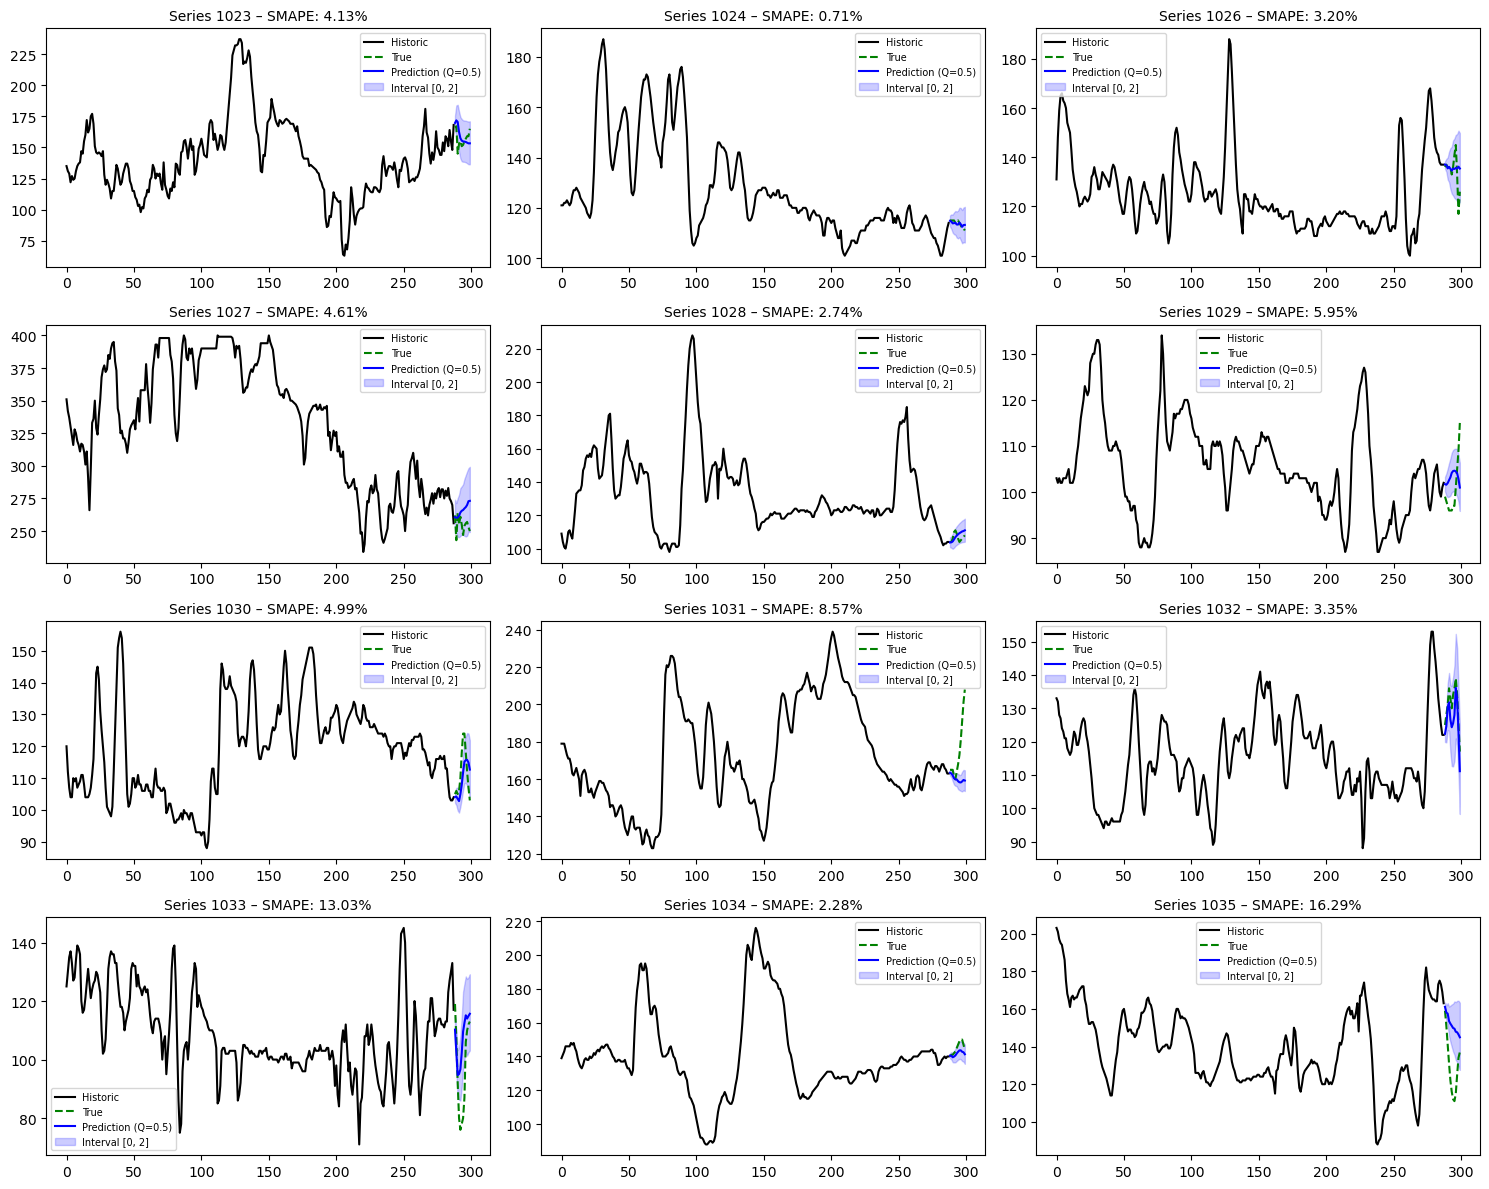

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# SMAPE function (optional for plot titles)
def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

# Quantile loss (if needed elsewhere)
def quantile_loss(y_true, y_pred, q):
    error = y_true - y_pred
    return np.mean(np.maximum(q * error, (q - 1) * error))

# Get predictions
raw_preds = tft.predict(test_dataloader, mode="raw", return_x=True, return_index=True)
y_pred = raw_preds.output["prediction"]
y_true = raw_preds.x["decoder_target"]
x = raw_preds.x
index_df = raw_preds.index

# Choose quantile indexes (check tft.hparams.quantiles to confirm order)
median_idx = 1
q_low = 0
q_high = 2

# Plot grid config
n_rows, n_cols = 4, 3
n_plots = n_rows * n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3), squeeze=False)

# Loop over prediction samples
for i in range(min(n_plots, len(index_df))):
    uid = index_df.iloc[i]["participant_id"]
    time_start = index_df.iloc[i]["ds"]
    encoder_len = x["encoder_lengths"][i].item()
    decoder_len = y_pred.shape[1]

    encoder_target = x["encoder_target"][i, :encoder_len].detach().cpu().numpy()
    target = y_true[i].detach().cpu().numpy()
    pred_all = y_pred[i].detach().cpu().numpy()
    pred_median = pred_all[:, median_idx]
    pred_q_low = pred_all[:, q_low]
    pred_q_high = pred_all[:, q_high]

    loss = smape(target, pred_median)

    row, col = divmod(i, n_cols)
    ax = axs[row][col]

    ax.plot(range(encoder_len), encoder_target, label="Historic", color="black")
    ax.plot(
        range(encoder_len, encoder_len + decoder_len),
        target,
        label="True",
        color="green",
        linestyle="--",
    )
    ax.plot(
        range(encoder_len, encoder_len + decoder_len),
        pred_median,
        label="Prediction (Q=0.5)",
        color="blue",
    )
    ax.fill_between(
        range(encoder_len, encoder_len + decoder_len),
        pred_q_low,
        pred_q_high,
        color="blue",
        alpha=0.2,
        label=f"Interval [{q_low}, {q_high}]",
    )

    ax.set_title(f"Series {uid} – SMAPE: {loss:.2f}%", fontsize=10)
    ax.legend(fontsize=7)

plt.tight_layout()
plt.show()

In [25]:
def calculate_metrics(t_grouped, train_df):
    static_vars = train_df[["participant_id"]].drop_duplicates()
    t_grouped = t_grouped.merge(static_vars, on="participant_id", how="left")
    
    metrics_df = (
        t_grouped.groupby("participant_id")
        .apply(
            lambda df: pd.Series({
                "SMAPE": smape(df["target"], df["prediction"]),
                "Quantile_Loss": quantile_loss(df["target"], df["prediction"], q=0.5),
                "MAE": np.mean(np.abs(df["prediction"] - df["target"])),
                "RMSE": np.sqrt(np.mean(np.square(df["prediction"] - df["target"]))),
            })
        )
        .reset_index()
    )
    return metrics_df

/tmp/ipykernel_67537/1714514927.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/tmp/ipykernel_67537/2432441264.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=metrics)


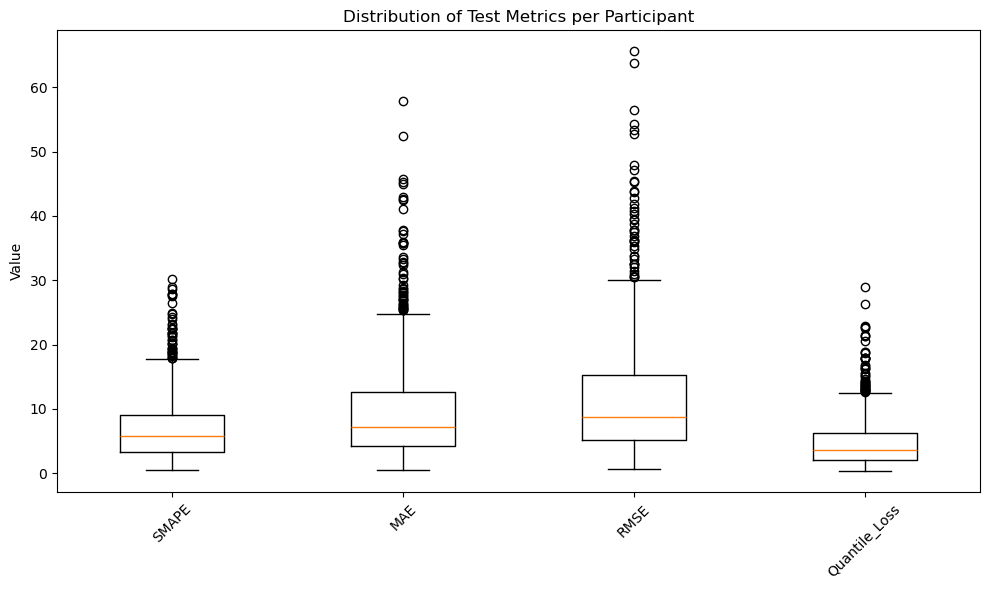

In [26]:
metrics_df = calculate_metrics(test_records, train_df=train)

import matplotlib.pyplot as plt

# Melt metrics to long format for plotting
long_df = metrics_df.melt(
    value_vars=["SMAPE", "MAE", "RMSE", "Quantile_Loss"],
    var_name="metric",
    value_name="value"
)

# Organize data for boxplot
metrics = ["SMAPE", "MAE", "RMSE", "Quantile_Loss"]
data = [long_df.loc[long_df["metric"] == m, "value"] for m in metrics]

# Plot
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=metrics)
plt.xticks(rotation=45)
plt.title("Distribution of Test Metrics per Participant")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

/tmp/ipykernel_67537/4171711302.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_67537/4171711302.py:10: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.boxplot(


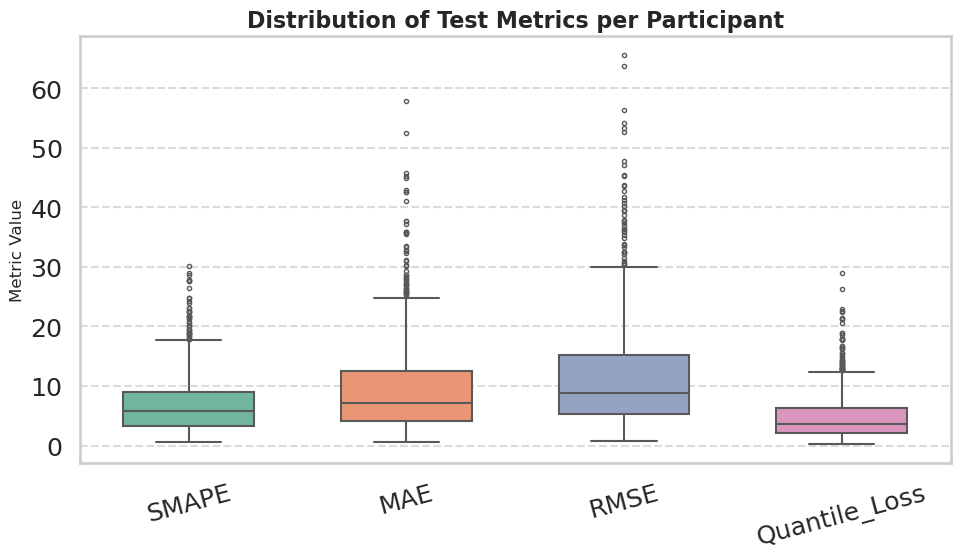

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style and palette
sns.set(style="whitegrid", context="talk", font_scale=1.1)
palette = sns.color_palette("Set2")

# Create boxplot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=long_df,
    x="metric",
    y="value",
    palette=palette,
    linewidth=1.5,
    fliersize=3,
    width=0.6
)

# Customize ticks and labels
plt.xticks(rotation=15)
plt.title("Distribution of Test Metrics per Participant", fontsize=16, weight="bold")
plt.xlabel("")
plt.ylabel("Metric Value", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [32]:
	
# Calculate average metrics across for SMAPE, MAE, RMSE, Quantile Loss across all participants. 
# Remember participant id is a categorical column we do not average over.
# You should subset the metrics_df to only include the columns you want to average.
average_metrics = metrics_df[["SMAPE", "MAE", "RMSE", "Quantile_Loss"]].mean().to_frame(name="Average").reset_index()
average_metrics.columns = ["Metric", "Average"]
print(average_metrics)

          Metric    Average
0          SMAPE   7.194570
1            MAE   9.655979
2           RMSE  11.643283
3  Quantile_Loss   4.827989


In [33]:
from scipy.stats import pearsonr

# Drop NaNs to avoid errors
df_scatter = test_records.dropna(subset=["target", "prediction"])

# Compute Pearson r
r, p_value = pearsonr(df_scatter["target"], df_scatter["prediction"])
print(f"Pearson r: {r:.4f}, p-value: {p_value:.4f}")

Pearson r: 0.9487, p-value: 0.0000


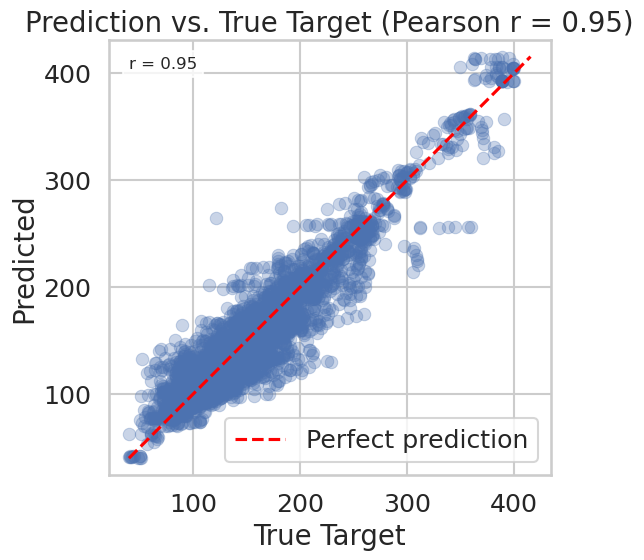

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(
    x="target", y="prediction", data=df_scatter,
    alpha=0.3, edgecolor=None
)

# Reference line (perfect prediction)
min_val = min(df_scatter["target"].min(), df_scatter["prediction"].min())
max_val = max(df_scatter["target"].max(), df_scatter["prediction"].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="red", label="Perfect prediction")

# Correlation text
plt.text(
    x=min_val, y=max_val, 
    s=f"r = {r:.2f}", 
    fontsize=12, 
    verticalalignment="top", 
    horizontalalignment="left", 
    bbox=dict(facecolor="white", alpha=0.8)
)

# Add correlation in title
plt.title(f"Prediction vs. True Target (Pearson r = {r:.2f})")

plt.xlabel("True Target")
plt.ylabel("Predicted")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

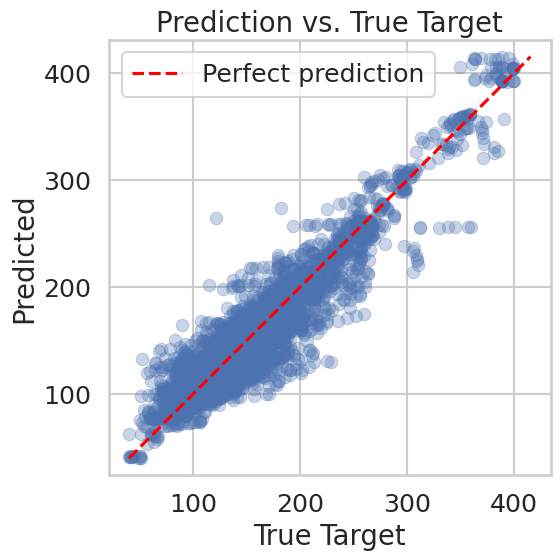

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Optionally filter out NaNs
df_scatter = test_records.dropna(subset=["target", "prediction"])

# Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(
    x="target", y="prediction", data=df_scatter,
    alpha=0.3, edgecolor=None
)

# Add 45° reference line
min_val = min(df_scatter["target"].min(), df_scatter["prediction"].min())
max_val = max(df_scatter["target"].max(), df_scatter["prediction"].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="red", label="Perfect prediction")

# Aesthetics
plt.xlabel("True Target")
plt.ylabel("Predicted")
plt.title("Prediction vs. True Target")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()

# Best Examples

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/shaksonisaac/miniconda3/envs/mambatf/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


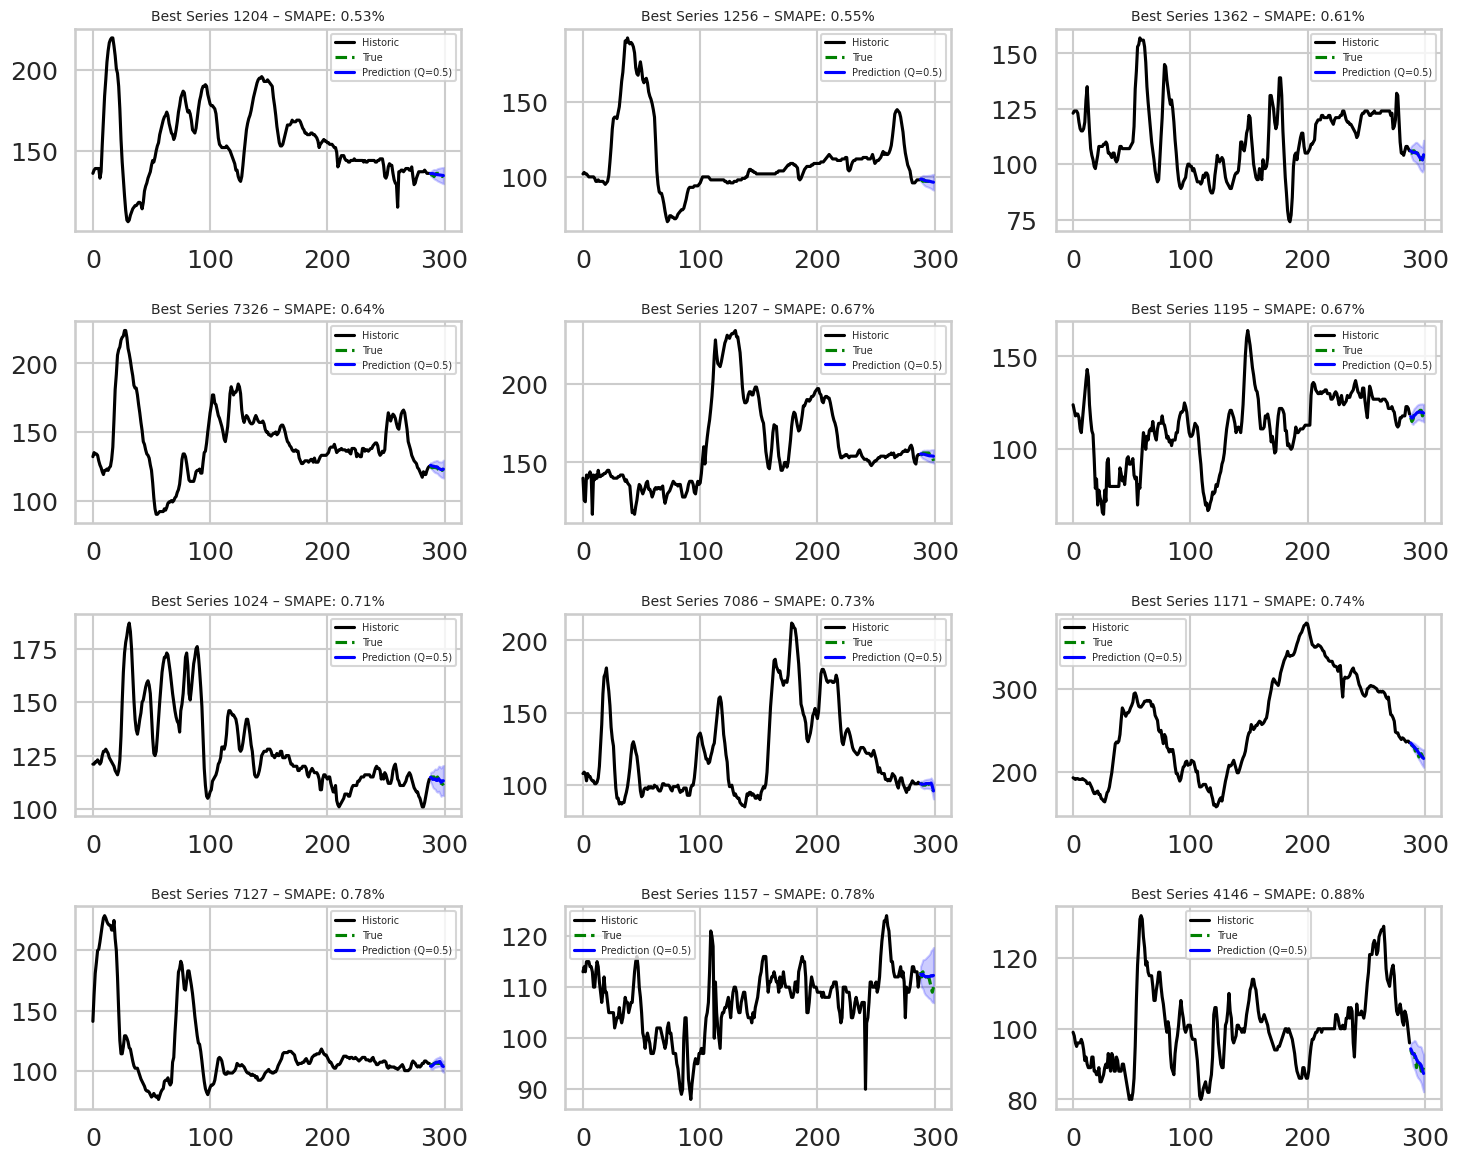

In [36]:
# Show the best examples:
import matplotlib.pyplot as plt
import numpy as np

# Define SMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

# Get predictions
raw_preds = tft.predict(test_dataloader, mode="raw", return_x=True, return_index=True)
y_pred = raw_preds.output["prediction"]
y_true = raw_preds.x["decoder_target"]
x = raw_preds.x
index_df = raw_preds.index

# Define quantile indices
median_idx = 1
q_low = 0
q_high = 2

# Collect all samples with SMAPE
smape_list = []

for i in range(len(index_df)):
    target = y_true[i].detach().cpu().numpy()
    pred_all = y_pred[i].detach().cpu().numpy()
    pred_median = pred_all[:, median_idx]
    smape_val = smape(target, pred_median)
    smape_list.append((i, smape_val))

# Sort by SMAPE (ascending = best)
best_indices = sorted(smape_list, key=lambda x: x[1])[:12]  # get top 12

# Plot config
n_rows, n_cols = 4, 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3), squeeze=False)

# Loop through top examples
for plot_idx, (i, loss) in enumerate(best_indices):
    uid = index_df.iloc[i]["participant_id"]
    time_start = index_df.iloc[i]["ds"]
    encoder_len = x["encoder_lengths"][i].item()
    decoder_len = y_pred.shape[1]

    encoder_target = x["encoder_target"][i, :encoder_len].detach().cpu().numpy()
    target = y_true[i].detach().cpu().numpy()
    pred_all = y_pred[i].detach().cpu().numpy()
    pred_median = pred_all[:, median_idx]
    pred_q_low = pred_all[:, q_low]
    pred_q_high = pred_all[:, q_high]

    row, col = divmod(plot_idx, n_cols)
    ax = axs[row][col]

    ax.plot(range(encoder_len), encoder_target, label="Historic", color="black")
    ax.plot(range(encoder_len, encoder_len + decoder_len), target, label="True", color="green", linestyle="--")
    ax.plot(range(encoder_len, encoder_len + decoder_len), pred_median, label="Prediction (Q=0.5)", color="blue")
    ax.fill_between(range(encoder_len, encoder_len + decoder_len), pred_q_low, pred_q_high, color="blue", alpha=0.2)

    ax.set_title(f"Best Series {uid} – SMAPE: {loss:.2f}%", fontsize=10)
    ax.legend(fontsize=7)

plt.tight_layout()
plt.show()

# Worst Examples

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


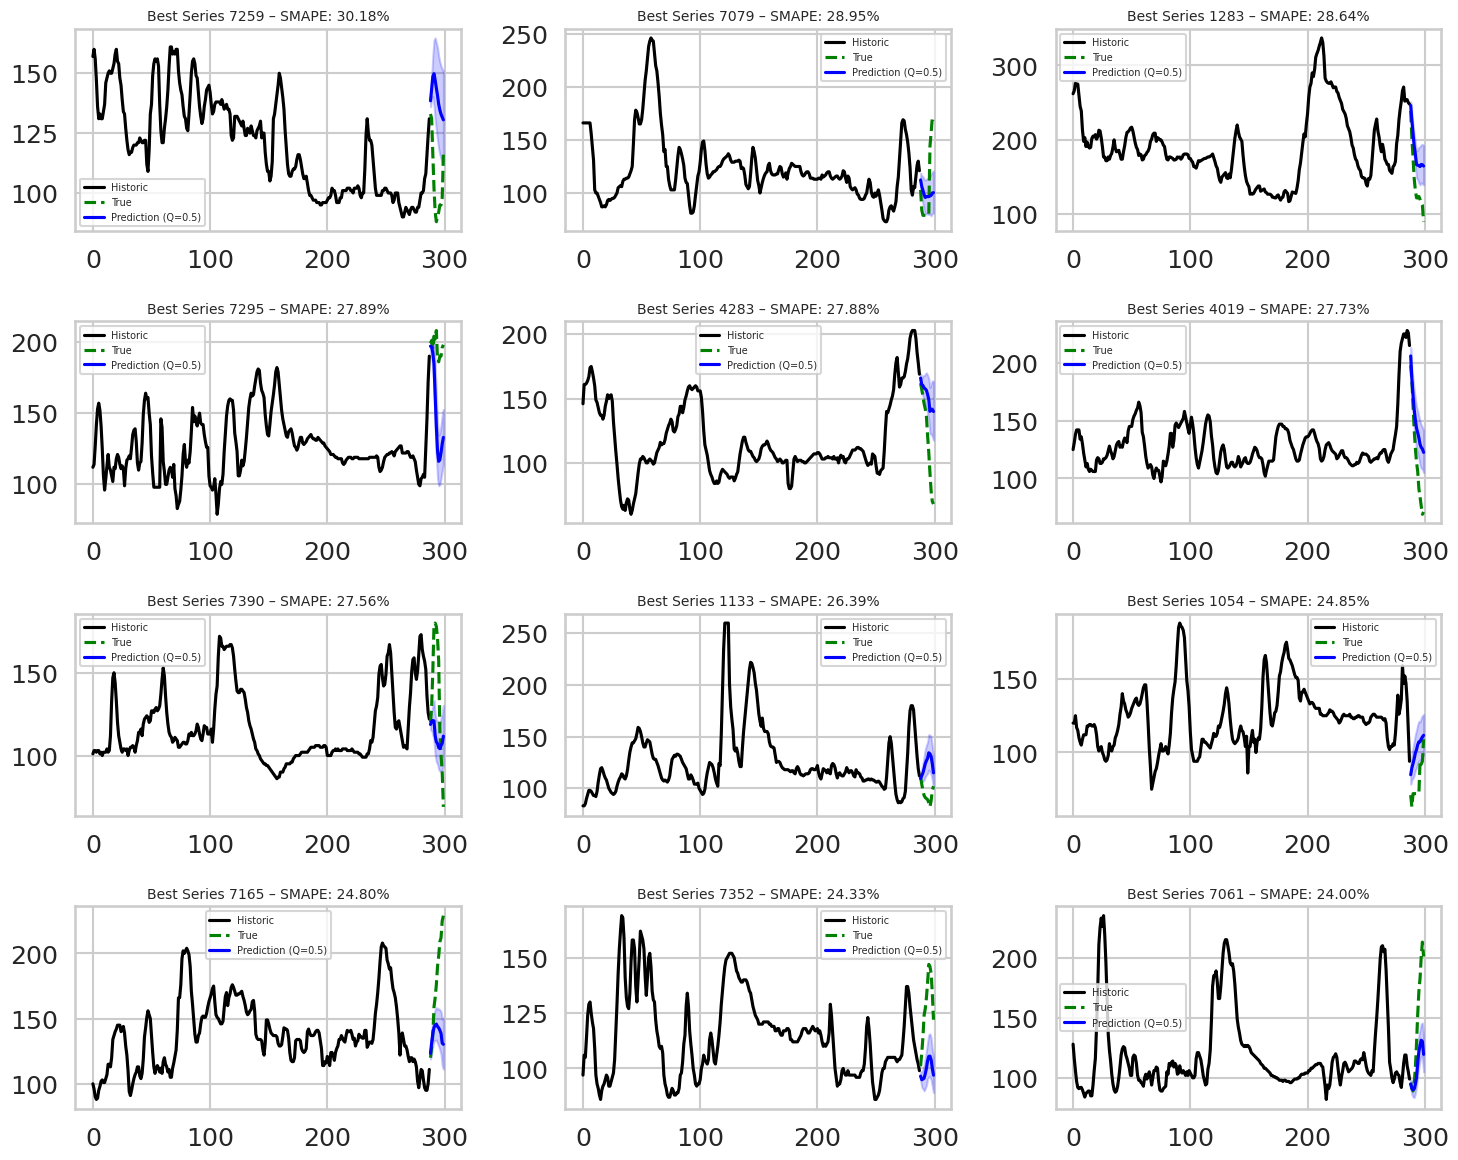

In [37]:
# Show the worst examples:
import matplotlib.pyplot as plt
import numpy as np

# Define SMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

# Get predictions
raw_preds = tft.predict(test_dataloader, mode="raw", return_x=True, return_index=True)
y_pred = raw_preds.output["prediction"]
y_true = raw_preds.x["decoder_target"]
x = raw_preds.x
index_df = raw_preds.index 

# Define quantile indices
median_idx = 1
q_low = 0
q_high = 2

# Collect all samples with SMAPE
smape_list = []

for i in range(len(index_df)):
    target = y_true[i].detach().cpu().numpy()
    pred_all = y_pred[i].detach().cpu().numpy()
    pred_median = pred_all[:, median_idx]
    smape_val = smape(target, pred_median)
    smape_list.append((i, smape_val))

# Sort by SMAPE
# Worst examples
worst_indices = sorted(smape_list, key=lambda x: x[1], reverse=True)[:12]

# Plot config
n_rows, n_cols = 4, 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3), squeeze=False)

# Loop through top examples
for plot_idx, (i, loss) in enumerate(worst_indices):
    uid = index_df.iloc[i]["participant_id"]
    time_start = index_df.iloc[i]["ds"]
    encoder_len = x["encoder_lengths"][i].item()
    decoder_len = y_pred.shape[1]

    encoder_target = x["encoder_target"][i, :encoder_len].detach().cpu().numpy()
    target = y_true[i].detach().cpu().numpy()
    pred_all = y_pred[i].detach().cpu().numpy()
    pred_median = pred_all[:, median_idx]
    pred_q_low = pred_all[:, q_low]
    pred_q_high = pred_all[:, q_high]

    row, col = divmod(plot_idx, n_cols)
    ax = axs[row][col]

    ax.plot(range(encoder_len), encoder_target, label="Historic", color="black")
    ax.plot(range(encoder_len, encoder_len + decoder_len), target, label="True", color="green", linestyle="--")
    ax.plot(range(encoder_len, encoder_len + decoder_len), pred_median, label="Prediction (Q=0.5)", color="blue")
    ax.fill_between(range(encoder_len, encoder_len + decoder_len), pred_q_low, pred_q_high, color="blue", alpha=0.2)

    ax.set_title(f"Best Series {uid} – SMAPE: {loss:.2f}%", fontsize=10)
    ax.legend(fontsize=7)

plt.tight_layout()
plt.show()